In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm

from analyzer.model.regression_model import RegressionModel
from data.io import Reader, Saver
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras.src.layers import Dense
from keras import Sequential, Input

# Постановка задачи
1. Провести анализ датасета 
2. Построить модель для предсказания price

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv

# Проверка целостности датасета

In [2]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv")
df = df_original.copy().reset_index(drop=True)
df.head(10)

,price,cost,sales,profit_margin,inventory,discount_percentage,delivery_days,category,material,color,location,season,store_type,brand,revenue
0,310.274113,212.889858,29,31.386523,90,7.694626,9,Bed,Glass,Blue,Suburban,Fall,Online,BrandA,8672.455407
1,410.988641,251.690184,34,38.759820,0,18.263939,6,Chair,Plastic,Black,Urban,Fall,Retail,BrandD,12716.512327
2,149.887473,116.849206,35,22.042047,185,1.041485,2,Chair,Fabric,Blue,Urban,Spring,Online,BrandB,7474.754493
3,212.061383,136.278803,21,35.736153,36,21.851586,3,Chair,Plastic,Black,Suburban,Summer,Retail,BrandD,6494.359712
4,388.118789,308.170228,15,20.598993,143,21.687030,9,Desk,Wood,Blue,Rural,Fall,Retail,BrandB,8595.461256
5,161.306646,143.909320,40,10.785250,7,27.946949,4,Bed,Metal,Black,Urban,Fall,Online,BrandC,-4828.308519
6,291.243365,238.432951,45,18.132744,47,24.987949,6,Table,Wood,Blue,Rural,Summer,Retail,BrandB,15713.303908
7,420.176443,355.563791,46,15.377505,180,15.432116,9,Bed,Metal,Black,Rural,Summer,Online,BrandD,16366.004507
8,461.434463,340.880442,38,26.125925,176,25.024057,2,Table,Glass,Red,Urban,Summer,Online,BrandC,14133.819598
9,88.156407,54.527411,43,38.146968,69,28.180050,6,Sofa,Plastic,White,Urban,Fall,Online,BrandA,12716.811115


In [3]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [4]:
# посмотрим на пропуски в данных
df.isna().sum()

price                  0
cost                   0
sales                  0
profit_margin          0
inventory              0
discount_percentage    0
delivery_days          0
category               0
material               0
color                  0
location               0
season                 0
store_type             0
brand                  0
revenue                0
dtype: int64

In [5]:
# Посмотрим статистику о датасете
df.describe()

,price,cost,sales,profit_margin,inventory,discount_percentage,delivery_days,revenue
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000
mean,274.495219,191.930107,24.924000,30.208571,97.715600,14.947616,4.89400,5926.853657
std,130.898452,98.590751,14.050067,11.536804,57.616228,8.621547,2.55902,6902.737604
min,50.704297,26.505895,1.000000,10.017692,0.000000,0.005556,1.00000,-14214.565505
25%,159.104890,106.399135,13.000000,20.230697,50.000000,7.760214,3.00000,1216.719195
50%,277.641809,189.336329,25.000000,30.297911,94.000000,14.915143,5.00000,5523.232714
75%,387.378046,263.188280,37.000000,40.134205,147.000000,22.292661,7.00000,10233.537982
max,499.872953,447.022911,49.000000,49.999535,199.000000,29.991229,9.00000,32922.078832


# Оптимизируем датасет

In [6]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [7]:
df.describe()

,price,cost,sales,profit_margin,inventory,discount_percentage,delivery_days,revenue
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000
mean,274.495219,191.930107,24.924000,30.208571,97.715600,14.947616,4.89400,5926.853657
std,130.898452,98.590751,14.050067,11.536804,57.616228,8.621547,2.55902,6902.737604
min,50.704297,26.505895,1.000000,10.017692,0.000000,0.005556,1.00000,-14214.565505
25%,159.104890,106.399135,13.000000,20.230697,50.000000,7.760214,3.00000,1216.719195
50%,277.641809,189.336329,25.000000,30.297911,94.000000,14.915143,5.00000,5523.232714
75%,387.378046,263.188280,37.000000,40.134205,147.000000,22.292661,7.00000,10233.537982
max,499.872953,447.022911,49.000000,49.999535,199.000000,29.991229,9.00000,32922.078832


In [8]:
df['sales'] = df['sales'].astype('uint8')
df['inventory'] = df['inventory'].astype('uint8')
df['delivery_days'] = df['delivery_days'].astype('uint8')

In [9]:
# проверяем
df.describe()

,price,cost,sales,profit_margin,inventory,discount_percentage,delivery_days,revenue
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000
mean,274.495219,191.930107,24.924000,30.208571,97.715600,14.947616,4.89400,5926.853657
std,130.898452,98.590751,14.050067,11.536804,57.616228,8.621547,2.55902,6902.737604
min,50.704297,26.505895,1.000000,10.017692,0.000000,0.005556,1.00000,-14214.565505
25%,159.104890,106.399135,13.000000,20.230697,50.000000,7.760214,3.00000,1216.719195
50%,277.641809,189.336329,25.000000,30.297911,94.000000,14.915143,5.00000,5523.232714
75%,387.378046,263.188280,37.000000,40.134205,147.000000,22.292661,7.00000,10233.537982
max,499.872953,447.022911,49.000000,49.999535,199.000000,29.991229,9.00000,32922.078832


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   uint8  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   uint8  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   uint8  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), object(7), uint8(3)
mem

Выводы:
1. float данные не удаётся преобразовать менее, чем float64
2. int данные удаётся конвертировать в uint8 (без отрицательных значений)
3. категории парсятся из object в category

# Проводим первичный визуальный анализ зависимостей данных

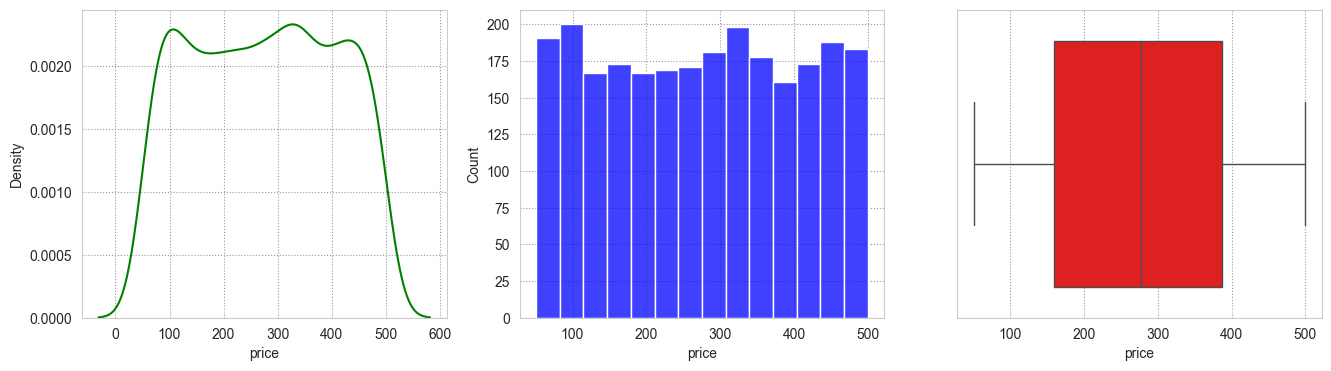

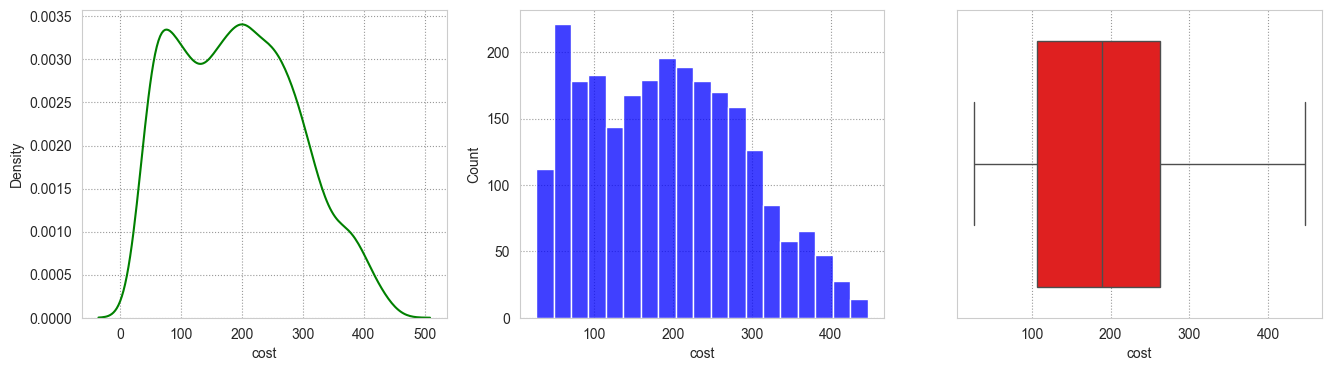

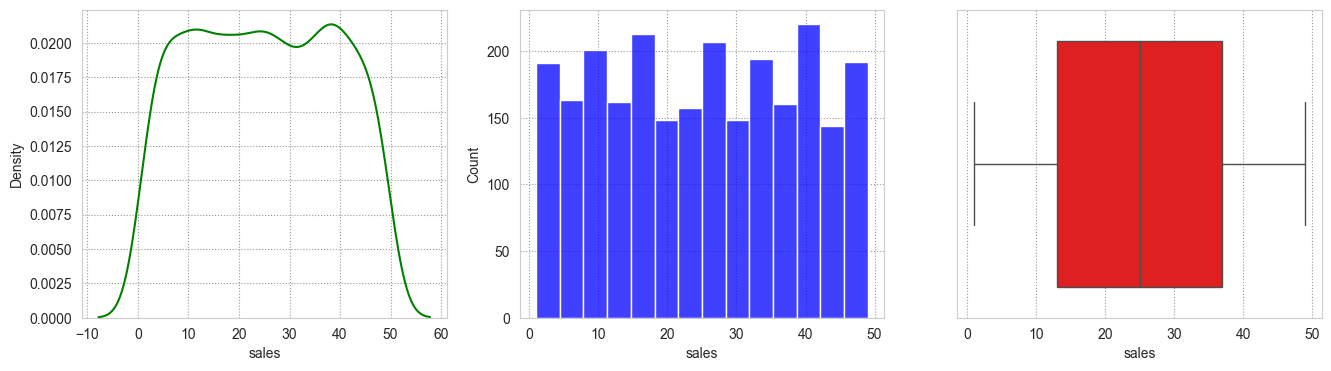

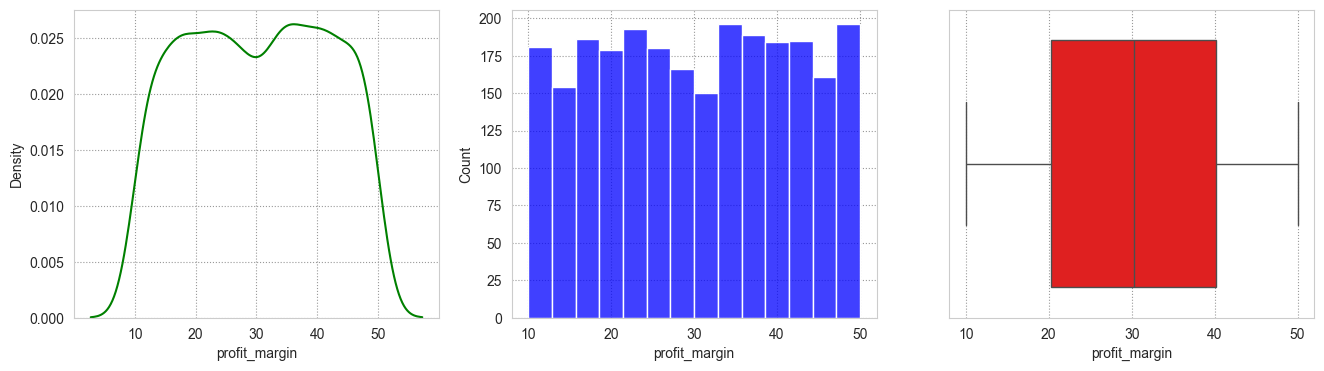

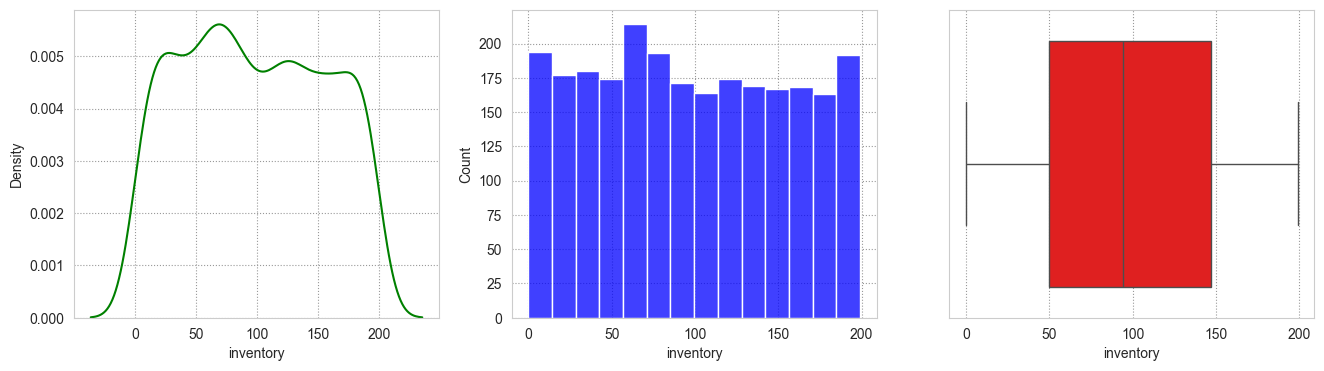

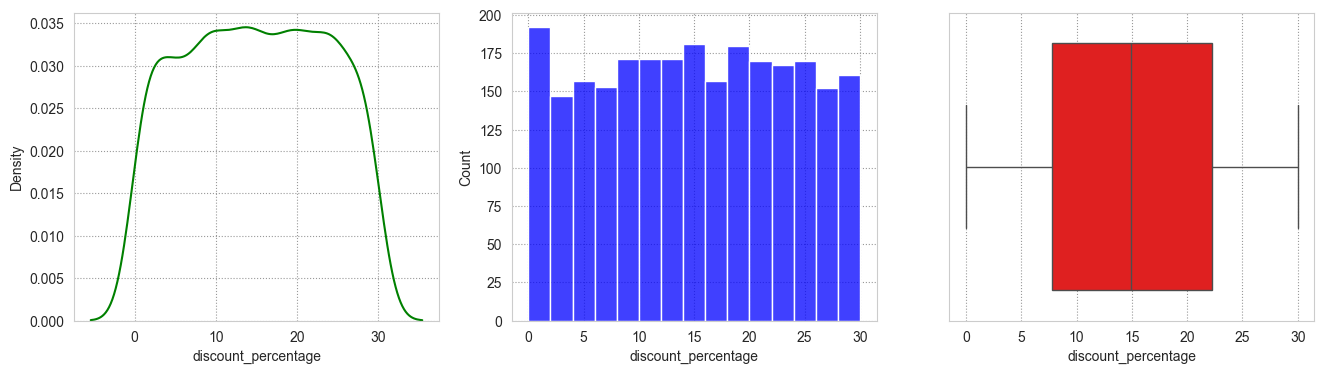

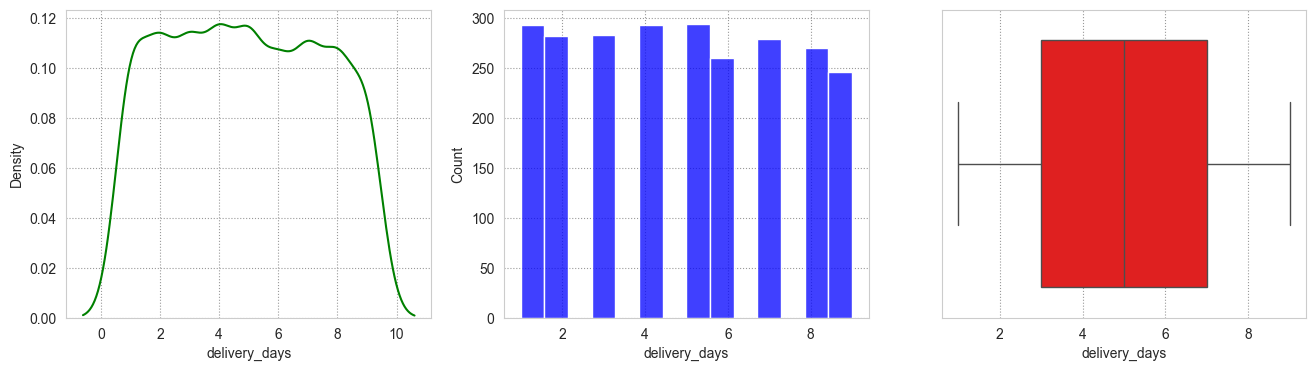

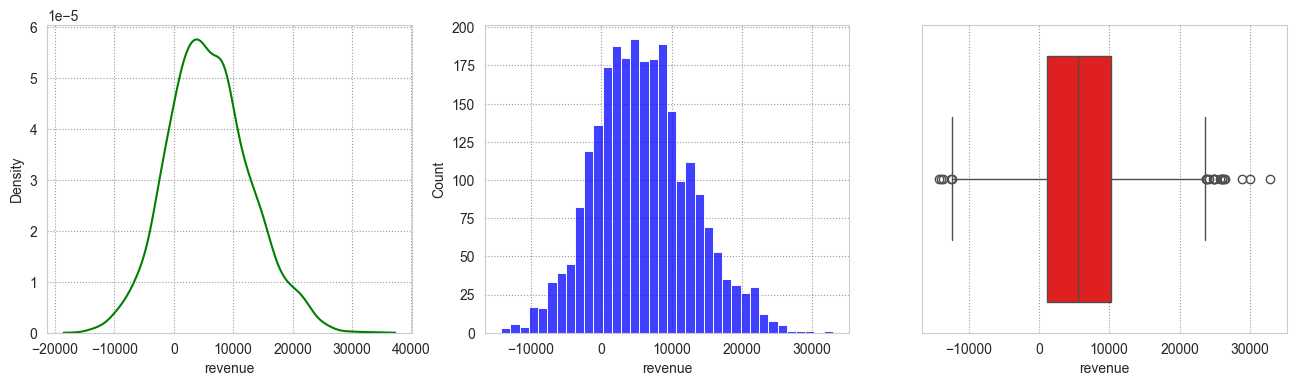

In [11]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

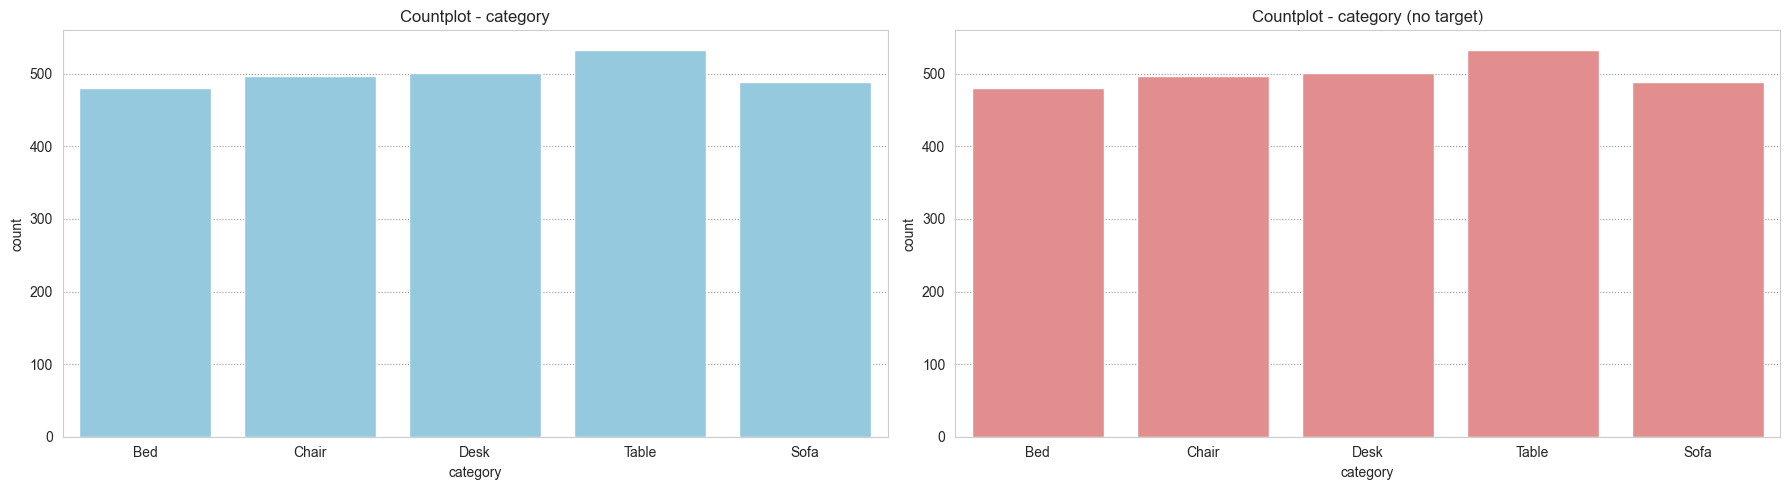

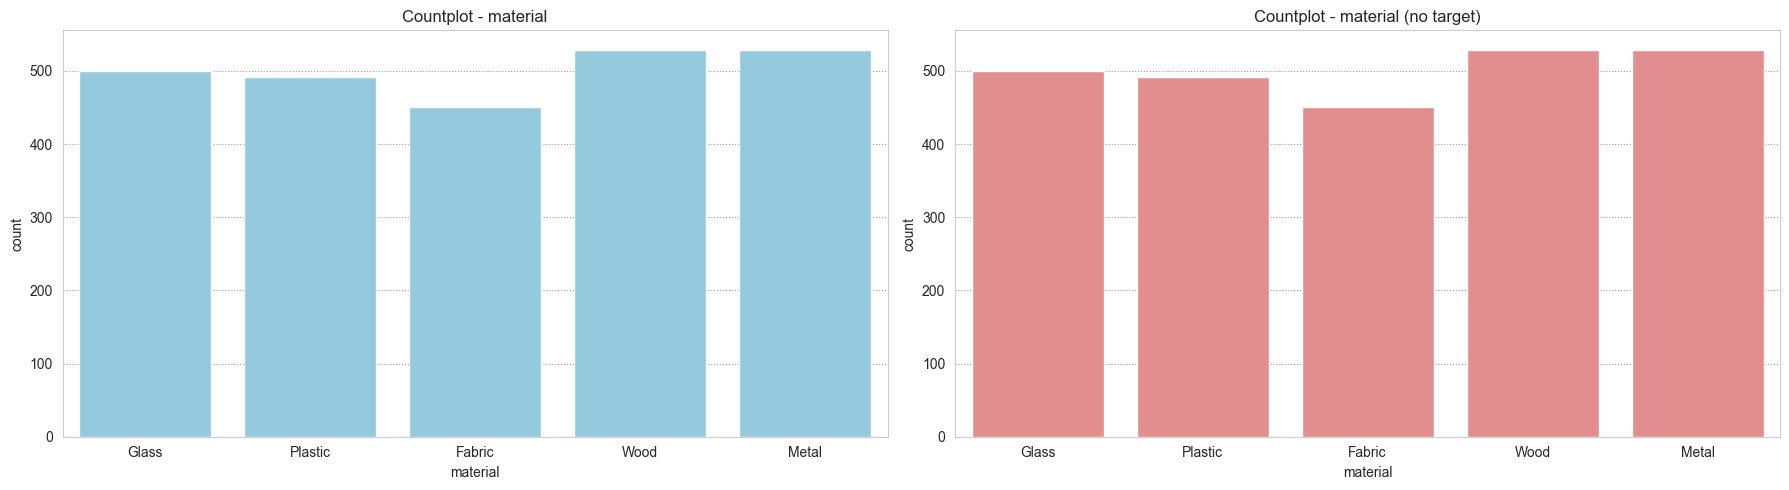

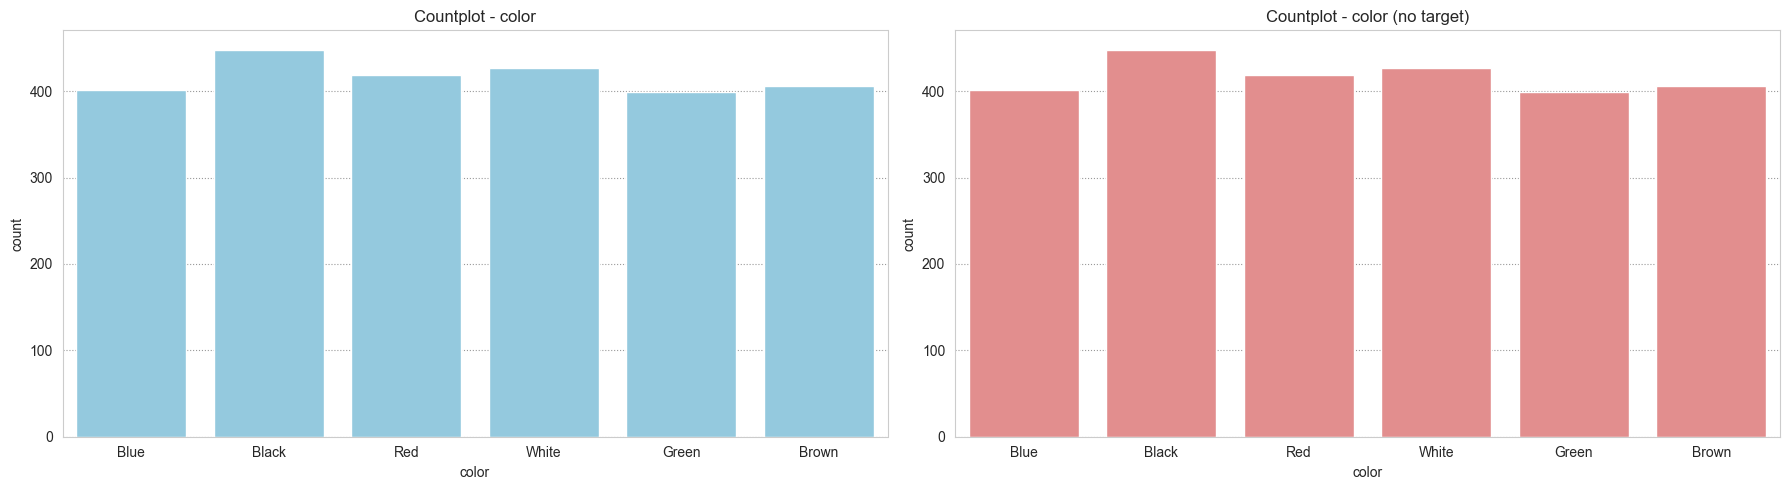

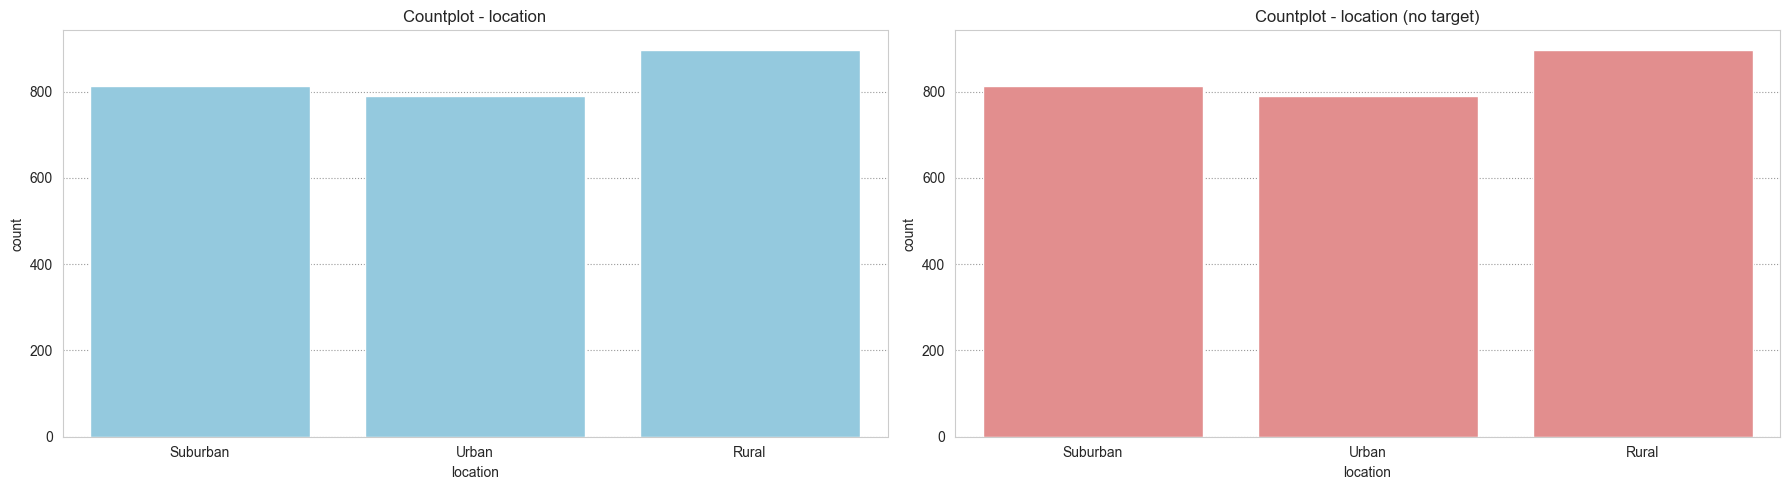

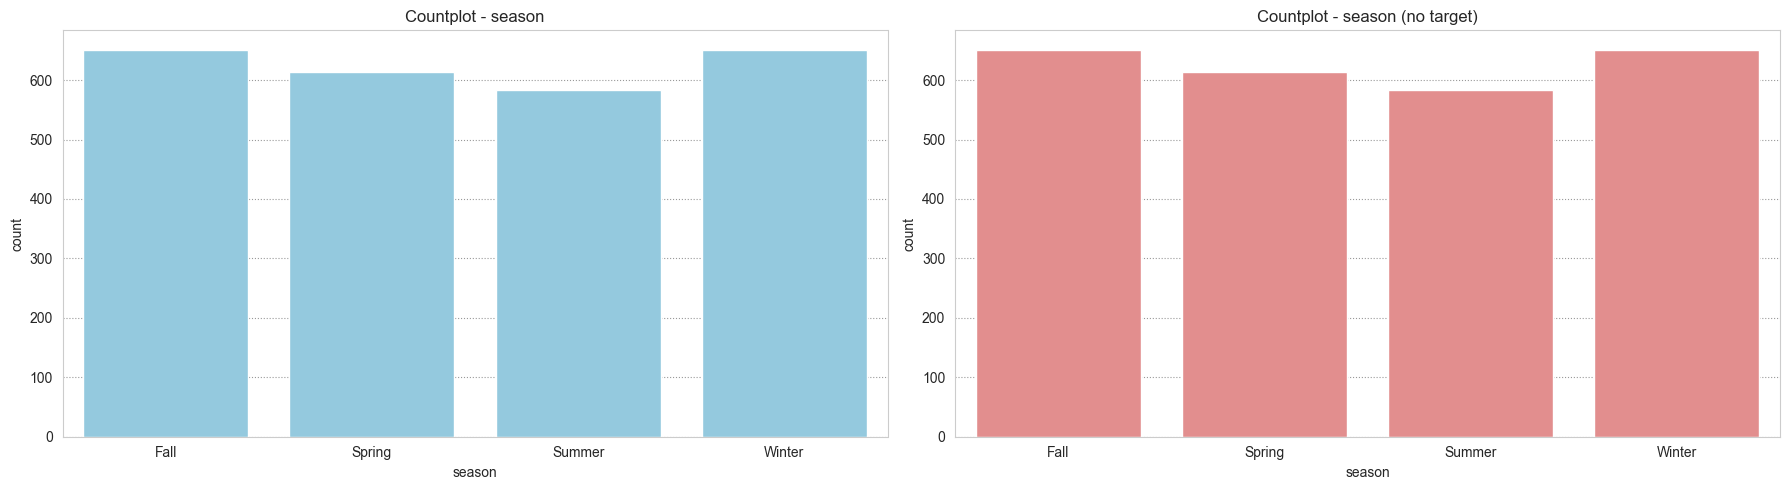

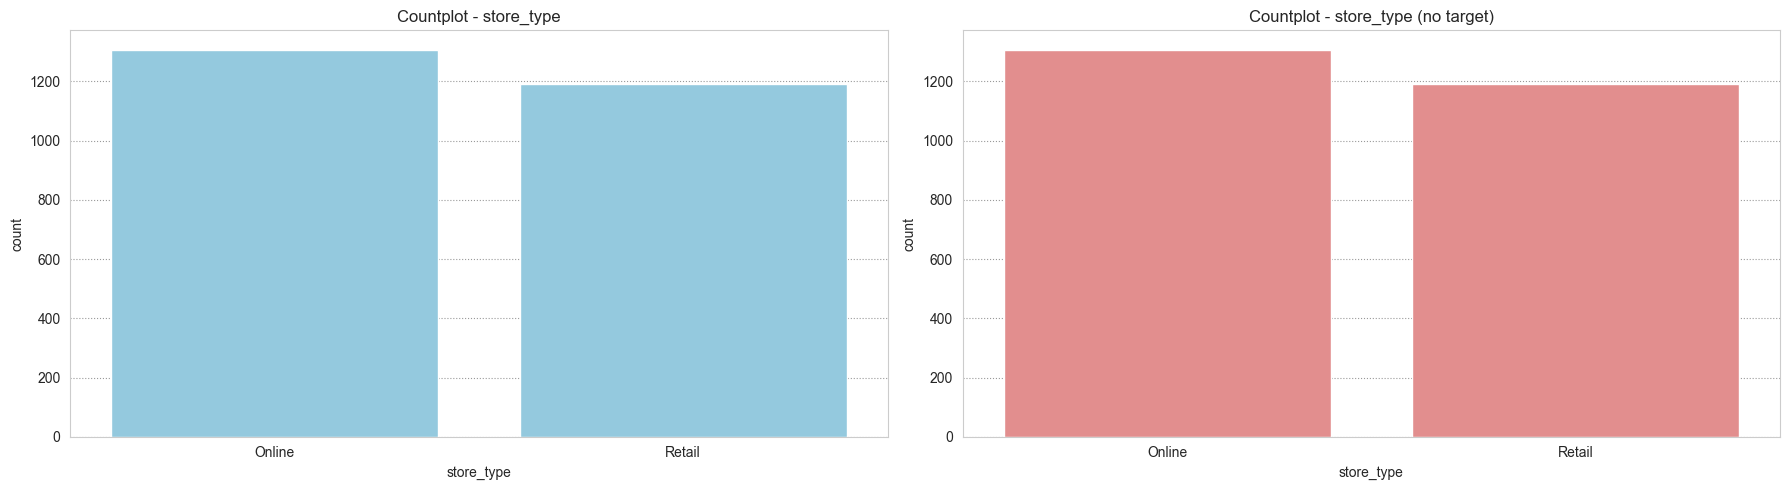

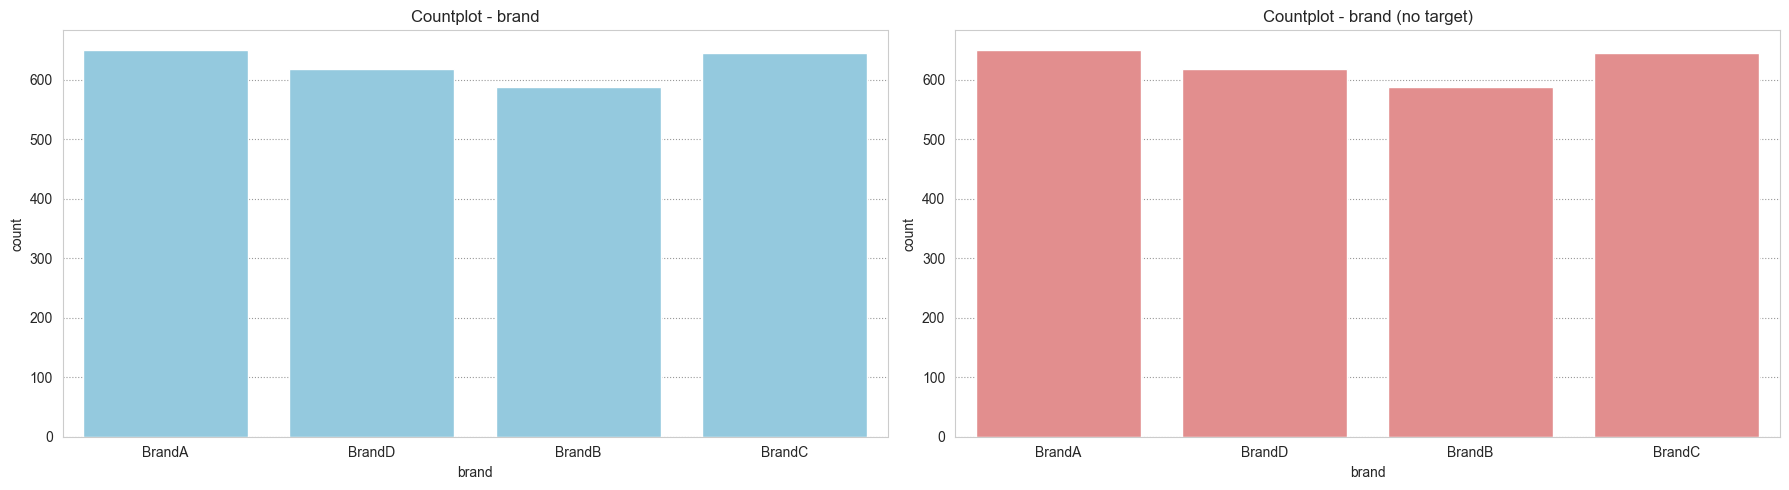

In [12]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

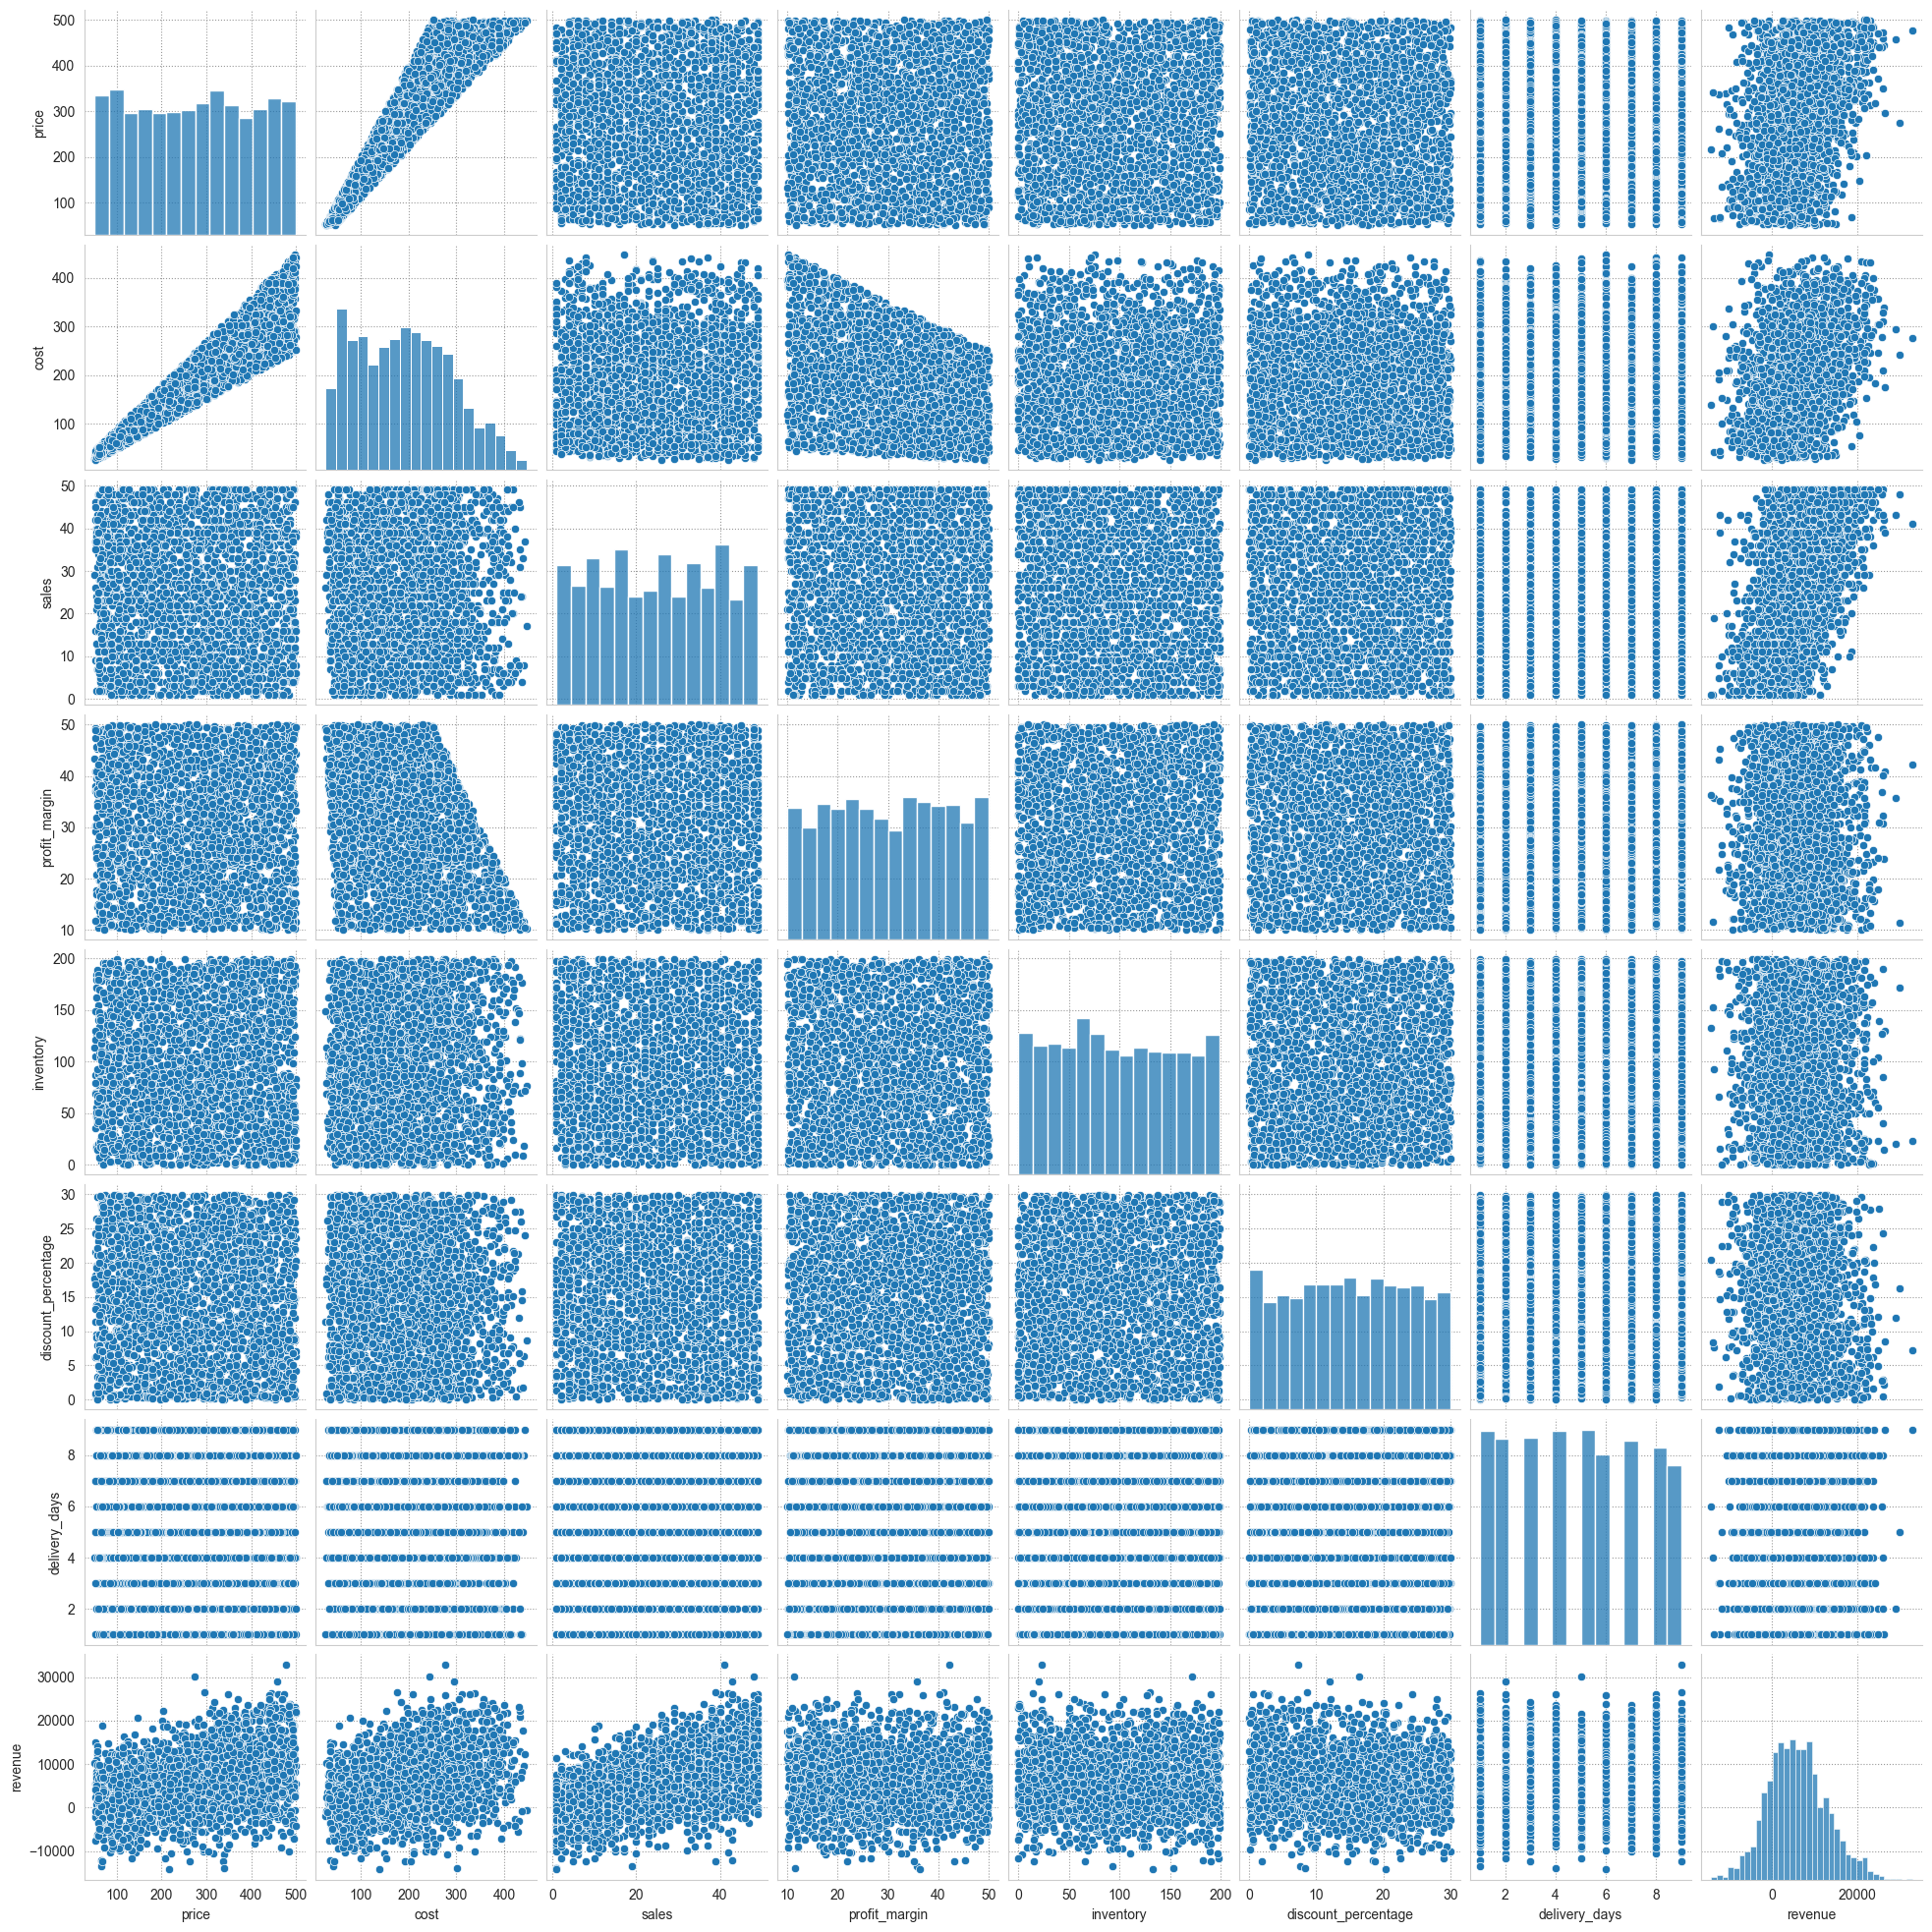

In [13]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

Выводы:
1. cost и revenue имеют близкое к нормальному распределению
2. выше определённого значения cost начинает падает profit_margin
3. подозрения на прямую корреляцию price (таргета) от cost
4. распределения price и cost не равны 

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

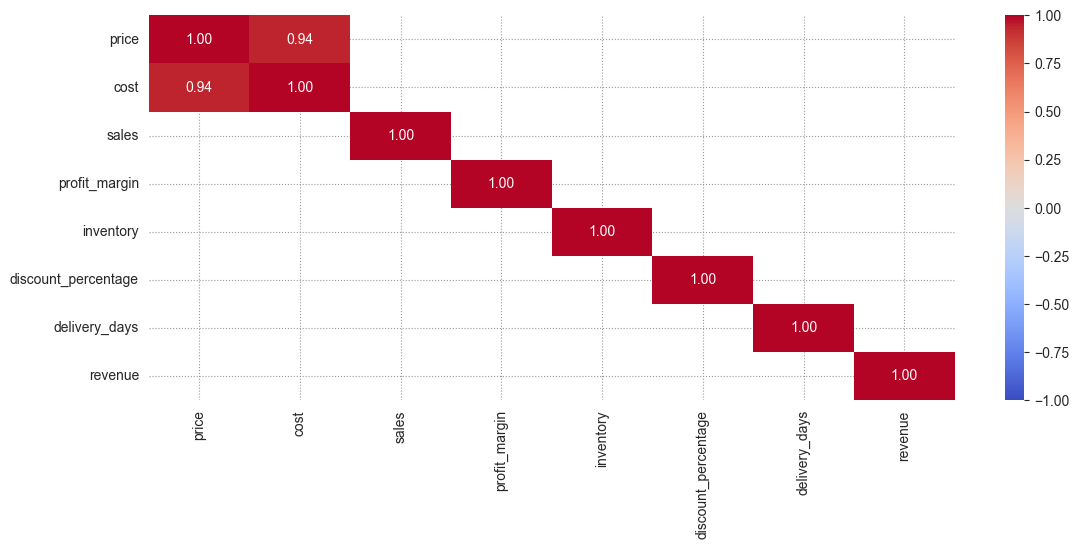

In [14]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [15]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"{column} и price:")
    groups = [df[column], df['price']]
    StatCriteria().mannwhitneyu(groups)

price и price:
Mann-Whitney U test
U_statistic = 3125000.000
Распределения двух выборок равны (p-value = 1.000).
cost и price:
Mann-Whitney U test
U_statistic = 1987986.000
Распределения двух выборок не равны (p-value = 0.000).
sales и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
profit_margin и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
inventory и price:
Mann-Whitney U test
U_statistic = 778193.000
Распределения двух выборок не равны (p-value = 0.000).
discount_percentage и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
delivery_days и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
revenue и price:
Mann-Whitney U test
U_statistic = 4972244.000
Распределения двух выборок не равны (p-value = 0.000).


In [16]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
cost,4.416676
sales,4.864945
profit_margin,5.206018
inventory,3.584181
discount_percentage,3.675485
delivery_days,4.153730
revenue,2.707721


Выводы:
1. сильная положительная корреляция price и cost
2. profit_margin с VIF > 5 намекает на некоторую мультиколлениарность
3. распределения непрерывных признаков и таргета не совпадают

## стат.обработка категориальных данных

In [17]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,category,material,color,location,season,store_type,brand
count,2500,2500,2500,2500,2500,2500,2500
unique,5,5,6,3,4,2,4
top,Table,Metal,Black,Rural,Fall,Online,BrandA
freq,533,529,448,897,651,1307,650


Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 17.471, dof = 20.000
Две переменные независимы (p-value = 0.622).
Chi-square test
chisq_statistic = 5.572, dof = 8.000
Две переменные независимы (p-value = 0.695).
Chi-square test
chisq_statistic = 17.272, dof = 12.000
Две переменные независимы (p-value = 0.140).
Chi-square test
chisq_statistic = 7.275, dof = 4.000
Две переменные независимы (p-value = 0.122).
Chi-square test
chisq_statistic = 10.448, dof = 12.000
Две переменные независимы (p-value = 0.577).
Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 27.980, dof = 20.000
Две переменные независимы (p-value = 0.110).
Chi-square test
chisq_statistic = 13.374, dof = 8.000
Две переменные независимы (p-value = 0.100).
Chi-square test
chisq_statistic = 7.905, dof = 12.000
Две переменные независимы (p-value = 0.793).
Chi-sq

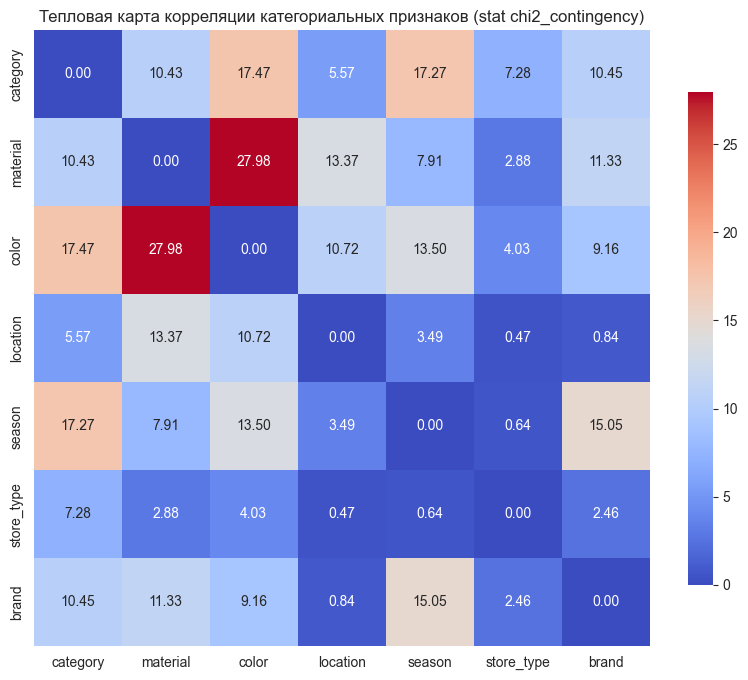

In [18]:
# Построим тепловую карту с категориальными переменными по хи-квадрат
Drawer.plot_heatmap_category(df)

Выводы:
1. небольшая зависимость категориальных признаков color и material
2. в категориальных данных нет большого числа уникальных значений
3. нет порядковых категориальных данных
4. store_type имеет два уникальных значения, можно использовать бинарную кодировку
5. season имеет циклические значения времён кода - циклическую кодировку
6. category, material, color, location, brand - подходят под one hot encoder

# Подготавливаем данные

In [19]:
# кодируем данные общего датасета
Encoder.booleanOneColumnEncoder(df['store_type'], 'Online')

0       1
1       0
2       1
3       0
4       0
       ..
2495    1
2496    0
2497    1
2498    0
2499    0
Name: store_type, Length: 2500, dtype: uint8

In [20]:
# разделяем данные
target = ['price']
exclude_features = ['price']
# exclude_features = ['price', 'inventory']  ## inventory - по Lasso

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

In [21]:
# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)

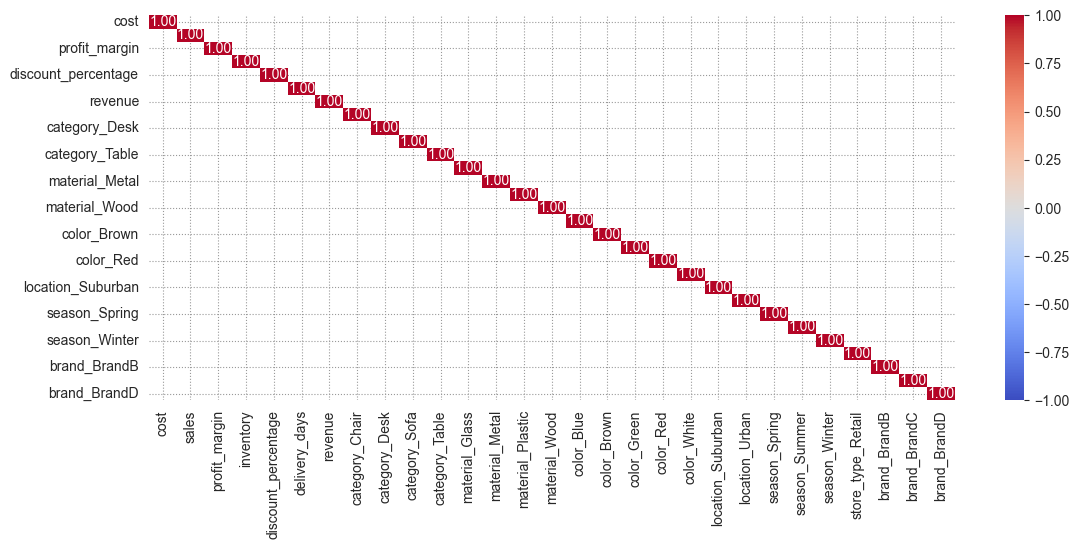

In [22]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(X_train, method='spearman', boundary=0.5)

In [23]:
# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
y_train, y_test, scaler_y = Normalizer().MinMaxScaler(y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

Выводы:
1. кодировка произведена
2. тепловая карта корреляции после кодировки в порядке

# Строим модель

In [24]:
# Применим метод OLS
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2316.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        03:11:56   Log-Likelihood:                 3037.4
No. Observations:                1875   AIC:                            -6015.
Df Residuals:                    1845   BIC:                            -5849.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cost                    1.2987    

In [25]:
residuals = y_test - y_pred
StatCriteria().shapiro(residuals)

Shapiro-Wilk Test
statistic = 0.989
Данные не соответствуют нормальному распределению (p-value = 0.000).


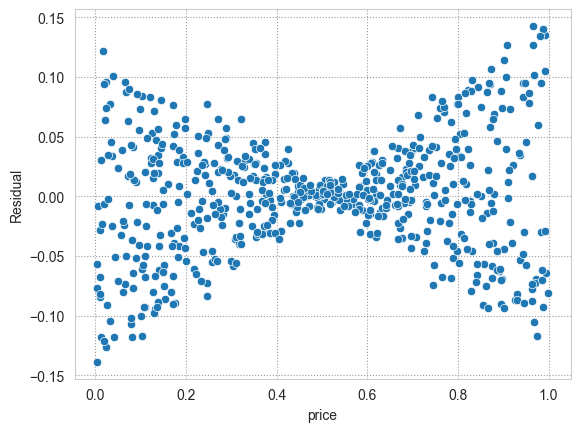

In [26]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [27]:
# Применим метод Lasso
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)

R²: 0.918
MAE: 0.07
MAPE: 63%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
cost: 1.05
sales: 0.00
profit_margin: 0.15
inventory: 0.00
discount_percentage: -0.00
delivery_days: 0.00
revenue: 0.00
category_Chair: 0.00
category_Desk: 0.00
category_Sofa: 0.00
category_Table: -0.00
material_Glass: 0.00
material_Metal: -0.00
material_Plastic: -0.00
material_Wood: -0.00
color_Blue: -0.00
color_Brown: 0.00
color_Green: -0.00
color_Red: -0.00
color_White: 0.00
location_Suburban: 0.00
location_Urban: -0.00
season_Spring: -0.00
season_Summer: 0.00
season_Winter: -0.00
store_type_Retail: -0.00
brand_BrandB: -0.00
brand_BrandC: 0.00
brand_BrandD: 0.00


In [28]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)

R²: 0.976
MAE: 0.03
MAPE: 29%
RMSE: 0
MSE: 0


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0980 - mape: inf - r2_score: -0.5671 - val_loss: 0.0180 - val_mape: 72.0936 - val_r2_score: -8688.9668
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0125 - mape: inf - r2_score: 0.8091 - val_loss: 0.0111 - val_mape: 73.2706 - val_r2_score: -4655.6426
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0066 - mape: inf - r2_score: 0.8991 - val_loss: 0.0080 - val_mape: 59.5753 - val_r2_score: -1633.1716
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0054 - mape: inf - r2_score: 0.9150 - val_loss: 0.0053 - val_mape: 41.4062 - val_r2_score: -347.2678
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0037 - mape: inf - r2_score: 0.9397 - val_loss: 0.0060 - val_mape: 37.5132 - val_r2_score: -18.4715
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0033 - mape: inf - r2_score: 0.9499 - val_loss: 0.0047 - val_mape: 44.4359 - val_r2_score: -1090.5952
Epoch 7/

<Axes: >

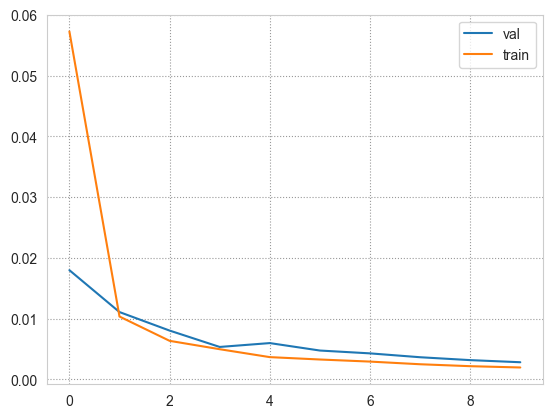

In [29]:
# Определение метрик
def r2_score(y_test_, y_pred_):
    y_test_ = tf.cast(y_test_, dtype='float64')
    y_pred_ = tf.cast(y_pred_, dtype='float64')
    SS_res = tf.reduce_sum(tf.square(y_test_ - y_pred_))
    SS_tot = tf.reduce_sum(tf.square(y_test_ - tf.reduce_mean(y_test_)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def mape(y_test_, y_pred_):
    y_test_ = tf.cast(y_test_, dtype='float64')
    y_pred_ = tf.cast(y_pred_, dtype='float64')
    return tf.reduce_mean(tf.abs((y_test_ - y_pred_) / y_test_)) * 100

# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Линейная активация для регрессии

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score, mape])

# Обучение модели
epochs = 10
batch_size=8
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')
#history.history['val_loss']